In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import scipy.interpolate as sinterp
import pickle
import cmocean

from sqlalchemy import create_engine, case
from sqlalchemy.orm import create_session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func

In [2]:
# where to find the sqlite database
basedir='/ocean/shared/SalishSeaCastData/DFO/BOT/'
dbname='DFO_OcProfDB.sqlite'

In [3]:
# start and end date to include in search
datelims=(dt.datetime(2010,1,1),dt.datetime(2022,1,1)); excludeSaanich=False

In [4]:
# The code in this cell sets up an interface to the database and gives 
# the tables simpler names for convenience
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
Base.prepare(engine, reflect=True)
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [5]:
# Some variables are available under multiple names, so if one is not available, another is used here
# CalcsTBL contains converted values (TEOS10) that were calculated based on the original DFO data
# ObsTBL contains original data from the DFO files
# Each variable defined here draws from a single table- either CalcsTBL OR ObsTBL

# Absolute Salinity:
SA=case([(CalcsTBL.Salinity_Bottle_SA!=None, CalcsTBL.Salinity_Bottle_SA)], else_=
         case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_=
         case([(CalcsTBL.Salinity__Unknown_SA!=None, CalcsTBL.Salinity__Unknown_SA)],
              else_=CalcsTBL.Salinity__Pre1978_SA)
        ))))

# Temperature:
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)],
              else_=ObsTBL.Temperature_Reversing_units)))
TemFlag=ObsTBL.Quality_Flag_Temp

# Conservative Temperature
CT=case([(CalcsTBL.Temperature_CT!=None, CalcsTBL.Temperature_CT)], else_=
     case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
     case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)],
          else_=CalcsTBL.Temperature_Reversing_CT)
    ))

In [6]:
# start and end year, month, and day for restricting results to a time range
start_y=datelims[0].year
start_m=datelims[0].month
start_d=datelims[0].day
end_y=datelims[1].year
end_m=datelims[1].month
end_d=datelims[1].day

# now we define a query that can pull the data we are interested in out of the database
# the list of arguments inside query(...) determins the columns that will be returned
#    StationTBL.sourceFile.label('source') means that the 'sourceFile' column from the 'StationTBL' table
#     will be included under the new column name 'source'

# The next section, select_from(...).join(..).join(...) specifies the relationships between the various tables included in the query:
# A primary key has a unique value for each row of the table it is associated with
# A foreign key references the primary key of a different table
# Here, StationTBL is joined to ObsTBL with the relationship that the StationTBL primary key, StationTBL.ID,
# matches the ObsTBL foreign key, ObsTBL.StationTBLID. The result is then joined to 
# CalcsTBL with the relationship CalcsTBL.ObsID==ObsTBL.ID, where ObsTBL.ID is the primary key of ObsTBL and 
# CalcsTBL.ObsID is the matching foreign key in CalcsTBL"""

# Arguments to filter() represent criteria that must be met for a row to be returned

qry=session.query(StationTBL.sourceFile.label('source'),
                  StationTBL.StartYear.label('Year'),
                  StationTBL.StartMonth.label('Month'),
                  StationTBL.StartDay.label('Day'),
                  StationTBL.StartHour.label('Hour'),
                  StationTBL.Lat,StationTBL.Lon,
                  ObsTBL.Pressure,
                  ObsTBL.Depth,
                  ObsTBL.Chlorophyll_Extracted,
                  ObsTBL.Chlorophyll_Extracted_units,
                  ObsTBL.Nitrate_plus_Nitrite.label('N'),
                  ObsTBL.Nitrate_plus_Nitrite_units,
                  ObsTBL.Silicate.label('Si'),
                  ObsTBL.Silicate_units,
                  ObsTBL.Phosphate.label('P'),
                  ObsTBL.Phosphate_units,
                  SA.label('AbsSal'), # defined in last cell based on values from CalcsTBL
                  CT.label('ConsT'), # defined in last cell basd on values from CalcsTBL
                  ObsTBL.Oxygen_Dissolved,
                  ObsTBL.Oxygen_Dissolved_units,
                  ObsTBL.Quality_Flag_Oxyg).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).\
           filter(and_(or_(StationTBL.StartYear>start_y,
                     and_(StationTBL.StartYear==start_y, 
                          StationTBL.StartMonth>start_m),
                     and_(StationTBL.StartYear==start_y, 
                          StationTBL.StartMonth==start_m, 
                          StationTBL.StartDay>=start_d)),
                 or_(StationTBL.StartYear<end_y,
                     and_(StationTBL.StartYear==end_y,StationTBL.StartMonth<end_m),
                     and_(StationTBL.StartYear==end_y,StationTBL.StartMonth==end_m, 
                          StationTBL.StartDay<end_d)), # The criteria up to here just restrict the data to fall between start date and end date
                StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121))) # These lat/lon conditions eliminate some data outside the domain

In [7]:
#Now we can execute the query, returning the results as a Pandas Dataframe (df1)
df1=pd.read_sql_query(qry.statement, engine)

In [8]:
# now the database connection can be closed because the queried data has been loaded into memory
session.close()
engine.dispose()

In [9]:
# some entries have depth and others have pressure: define new varible Z for depth
df1['Z']=np.where(df1['Depth']>=0,df1['Depth'],-1.0*gsw.z_from_p(p=df1['Pressure'].values,lat=df1['Lat'].values))


In [10]:
# display first 3 rows:
df1.head(3)

,source,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Chlorophyll_Extracted,...,Si,Silicate_units,P,Phosphate_units,AbsSal,ConsT,Oxygen_Dissolved,Oxygen_Dissolved_units,Quality_Flag_Oxyg,Z
0,req20160113/UBC EO data request 20160113 a/201...,2010.0,6.0,2.0,10.506111,51.6785,-127.332,2.8,NaN,NaN,...,NaN,umol/L,NaN,umol/L,28.399731,9.276901,NaN,mL/L,None,2.775560
1,req20160113/UBC EO data request 20160113 a/201...,2010.0,6.0,2.0,10.506111,51.6785,-127.332,3.8,NaN,NaN,...,NaN,umol/L,NaN,umol/L,30.240832,8.928219,NaN,mL/L,None,3.766823
2,req20160113/UBC EO data request 20160113 a/201...,2010.0,6.0,2.0,10.506111,51.6785,-127.332,4.7,NaN,NaN,...,NaN,umol/L,NaN,umol/L,30.222246,8.940301,NaN,mL/L,None,4.658955


In [11]:
df1.Phosphate_units.unique()

array(['umol/L', None], dtype=object)

In [12]:
df1.Nitrate_plus_Nitrite_units.unique()

array(['umol/L', None], dtype=object)

In [13]:
# unit conversion necessary for some oxygen values
df1.Oxygen_Dissolved_units.unique()

array(['mL/L', None, 'umol/kg'], dtype=object)

In [14]:
# 1 ml/l of O2 is approximately 43.570 µmol/kg
np.where(df1['Depth']>=0,df1['Depth'],-1.0*gsw.z_from_p(p=df1['Pressure'].values,lat=df1['Lat'].values))

df1['O2_umolkg']=np.where(df1['Oxygen_Dissolved_units']=='umol/kg',df1['Oxygen_Dissolved'],
                         df1['Oxygen_Dissolved']*43.57)

In [15]:
# define P* as P-N/16 
df1['Pstar']=df1['P']-1/16*df1['N']

In [16]:
# Saanich Inlet values:
df1S=df1.loc[(df1.N>=0)&(df1.P>=0)&(df1.Lon>-123.65)&(df1.Lon<-123.43)&(df1.Lat>48.45)&(df1.Lat<48.75)]

In [17]:
# SoG values
df1C=df1.loc[(df1.N>=0)&(df1.P>=0)&(df1.Lon>-124.)&(df1.Lon<-123.59)&(df1.Lat>49.25)&(df1.Lat<49.44)]

In [18]:
# model bathymetry for plotting
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

<ipython-input-19-c8e9d7f8a0ad>:2: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(bathylon,bathylat,bathyZ,[0,],


Text(0.5, 1.0, 'Legend: red-Saanich Inlet, blue-SoG')

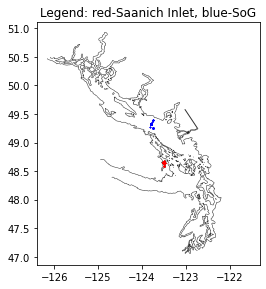

In [19]:
fig,ax=plt.subplots(1,1,figsize=(4,9))
contour_lines = ax.contour(bathylon,bathylat,bathyZ,[0,],
                colors='black',zorder=2,linewidths=.5,alpha=.8)
ax.set_aspect(1.3)
ax.plot(df1S.Lon,df1S.Lat,'r.',ms=1)
ax.plot(df1C.Lon,df1C.Lat,'b.',ms=1)
#ax.set_xlim(-123.65,-123.43)
#ax.set_ylim(48.45,48.8)
ax.set_title('Legend: red-Saanich Inlet, blue-SoG')

Text(0.5, 1.0, 'Pstar')

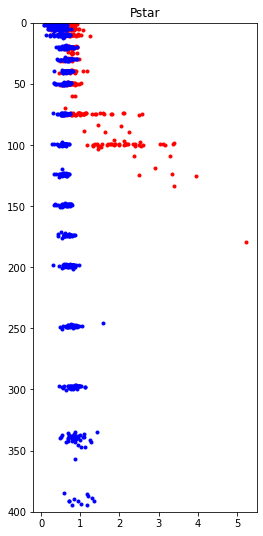

In [20]:
# The elevated P* below about 70m in Saanich Inlet indicates excess phosphorus relative to the 
# Redfield ratio, consistent with denitrification
fig,ax=plt.subplots(1,1,figsize=(4,9))
ax.plot(df1S.Pstar,df1S.Z,'r.')
ax.plot(df1C.Pstar,df1C.Z,'b.')
ax.set_xlim(-.2,5.5)
ax.set_ylim(400,0)
ax.set_title('Pstar')

Text(0.5, 1.0, 'Silicate (umol/L)')

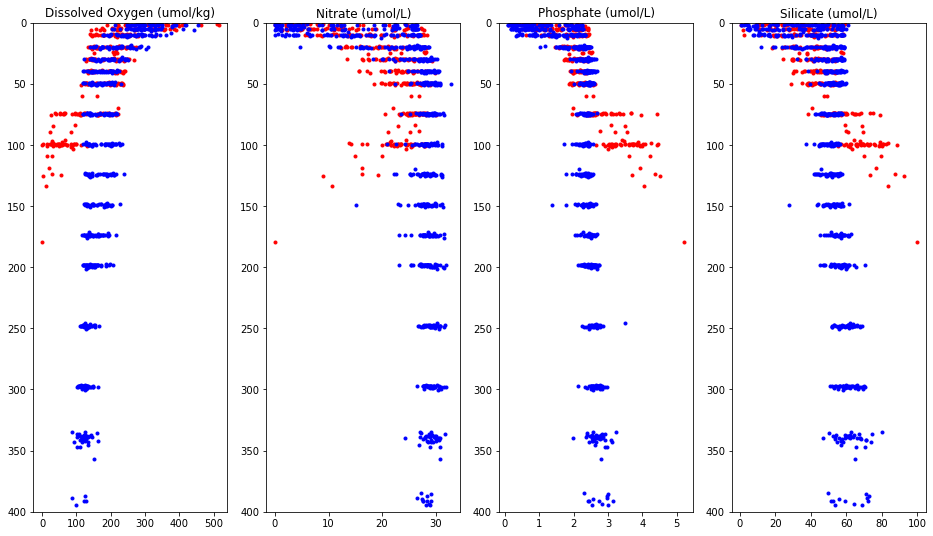

In [21]:
# The elevated P* below about 70m in Saanich Inlet indicates excess phosphorus relative to the 
# Redfield ratio, consistent with denitrification
fig,ax=plt.subplots(1,4,figsize=(16,9))
ax[0].plot(df1S.O2_umolkg,df1S.Z,'r.')
ax[0].plot(df1C.O2_umolkg,df1C.Z,'b.')
#ax.set_xlim(-.2,5.5)
ax[0].set_ylim(400,0)
ax[0].set_title('Dissolved Oxygen (umol/kg)')
ax[1].plot(df1S.N,df1S.Z,'r.')
ax[1].plot(df1C.N,df1C.Z,'b.')
#ax.set_xlim(-.2,5.5)
ax[1].set_ylim(400,0)
ax[1].set_title('Nitrate (umol/L)')
ax[2].plot(df1S.P,df1S.Z,'r.')
ax[2].plot(df1C.P,df1C.Z,'b.')
#ax.set_xlim(-.2,5.5)
ax[2].set_ylim(400,0)
ax[2].set_title('Phosphate (umol/L)')
ax[3].plot(df1S.Si,df1S.Z,'r.')
ax[3].plot(df1C.Si,df1C.Z,'b.')
#ax.set_xlim(-.2,5.5)
ax[3].set_ylim(400,0)
ax[3].set_title('Silicate (umol/L)')